In [0]:
import numpy as np
from math import *
import matplotlib.pyplot as plt

In [0]:
class BinomialCRROption(object):
    def __init__(self, S0, K, r, T, n, sigma, is_call, is_european):
        self.S0 = S0
        self.K = K
        self.r = r
        self.T = T
        self.n = n 
        self.sigma = sigma
        self.is_call = is_call
        self.is_european = is_european

        '''Computed Values'''
        self.u = exp(sigma*sqrt(T/n))
        self.d = 1/self.u
        self.qu = (exp(r*T/n)-self.d)/(self.u-self.d)
        self.qd = 1-self.qu
        self.df = exp(-r * T/n)
    
    def _initialize_stock_price_tree_(self):   
        stocktree = np.zeros([self.n+1, self.n+1])
        for i in range(self.n+1):
            for j in range(self.n+1):
                if j <= i:
                    stocktree[i, j] = self.S0*(self.d**(i-j))*(self.u**j)
        return stocktree
    
    def stock_price_tree(self):
        tree = self._initialize_stock_price_tree_()
        return tree
    
    def _initialize_european_option_price_tree_(self):
        stock_tree = self._initialize_stock_price_tree_()
        eur_price_tree = np.zeros([self.n+1,self.n+1])
        eur_price_tree[self.n] = (stock_tree[self.n]-self.K).clip(min=0) if self.is_call else (self.K-stock_tree[n]).clip(min=0)
        for i in reversed(range(self.n)):
            for j in reversed(range(self.n)):
                if j<=i:
                    eur_price_tree[i,j] = (eur_price_tree[i+1,j+1]*self.qu + eur_price_tree[i+1,j]*self.qd)*self.df
        return eur_price_tree
    
    def _initialize_american_option_price_tree_(self):
        stock_tree = self._initialize_stock_price_tree_()
        exercise_pts = []
        amr_price_tree = np.zeros([self.n+1,self.n+1])
        amr_price_tree[self.n] = (stock_tree[self.n]-self.K).clip(min=0) if self.is_call else (self.K-stock_tree[self.n]).clip(min=0)
        for i in reversed(range(self.n)):
            for j in reversed(range(self.n)):
                if j<=i:
                    amr_payoff = (stock_tree[i,j]-self.K) if self.is_call else (self.K-stock_tree[i,j])
                    amr_price_tree[i,j] = max((amr_price_tree[i+1,j+1]*self.qu + amr_price_tree[i+1,j]*self.qd)*self.df,amr_payoff)
                    if (amr_price_tree[i+1,j+1]*self.qu + amr_price_tree[i+1,j]*self.qd)*self.df < amr_payoff:
                        exercise_pts.append((i,j,stock_tree[i,j],amr_price_tree[i,j]))
        
        # handling terminal points for EPA
        for i in range(self.n):
            if (amr_price_tree[self.n-1][i]!=0) & (float(self.r)!=float(0.0)):
                exercise_pts.append((self.n,i,stock_tree[self.n,i],amr_price_tree[self.n,i]))
        
        return amr_price_tree, exercise_pts
    
    def price(self):
        if self.is_european:
            p = self._initialize_european_option_price_tree_()[0][0]
        else:
            p = self._initialize_american_option_price_tree_()[0][0][0]
        return p
            
    def option_price_tree(self):
        if self.is_european:
            p_tree = self._initialize_european_option_price_tree_()
        else:
            p_tree = self._initialize_american_option_price_tree_()[0]
        return p_tree
    
    def exercise_frontier(self):
        stock_tree = self._initialize_stock_price_tree_()
        if self.is_european:
            return("Only possible for American Options")
        
        exercise_pts = self._initialize_american_option_price_tree_()[1]
        x = []
        for i in range(self.n+1):
            x.extend([i]*(i+1)) 

        y = []
        for i in range(len(stock_tree)):
            y.extend(stock_tree[i][stock_tree[i] != 0]) 

        x_co_ordinates = [i[0] for i in exercise_pts]
        y_co_ordinates = [i[2] for i in exercise_pts]    

        plt.scatter(x,y,color="blue")
        plt.scatter(x_co_ordinates,y_co_ordinates,color="red")
        plt.xlabel('Steps')
        plt.ylabel('Stock Price')
        plt.legend(["Early Exercise","No Early Exercise"],loc="upper left")
        
        EPA = np.zeros([self.n+1,self.n+1])
        ex_cood = [[i[0],i[1]] for i in exercise_pts]
        for i in ex_cood:
            EPA[i[0],i[1]] = 1
            
        return EPA

# Effect of increasing r on Exercise Frontier¶


7.21849041410787


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

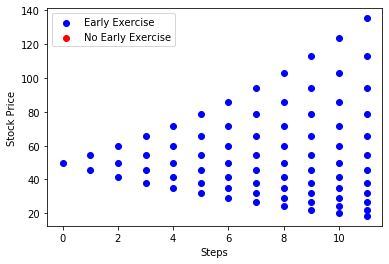

In [3]:
option = BinomialCRROption(S0=50, K=52, r=0.0, T=1, n=11, sigma=0.3, is_call=False, is_european=False)
print(option.price())
#print(option.option_price_tree())
option.exercise_frontier()

6.953855742132798


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.]])

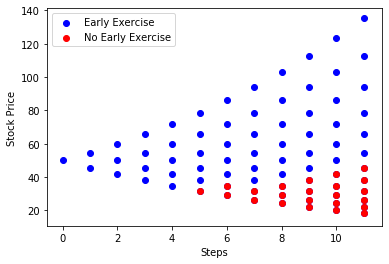

In [4]:
option = BinomialCRROption(S0=50, K=52, r=0.01, T=1, n=11, sigma=0.3, is_call=False, is_european=False)
print(option.price())
#print(option.option_price_tree())
option.exercise_frontier()

5.168447180758061


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.]])

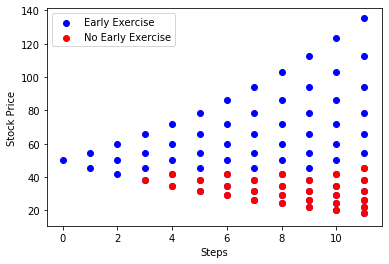

In [5]:
option = BinomialCRROption(S0=50, K=52, r=0.10, T=1, n=11, sigma=0.3, is_call=False, is_european=False)
print(option.price())
#print(option.option_price_tree())
option.exercise_frontier()

# Effect of increasing n on Exercise Frontier¶


6.170487868982785


array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0.]])

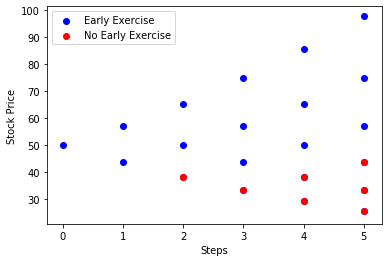

In [6]:
option = BinomialCRROption(S0=50, K=52, r=0.05, T=1, n=5, sigma=0.3, is_call=False, is_european=False)
print(option.price())
#print(option.option_price_tree())
option.exercise_frontier()

6.072891946432653


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]])

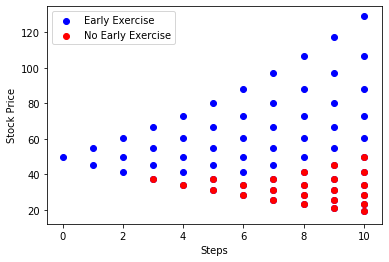

In [7]:
option = BinomialCRROption(S0=50, K=52, r=0.05, T=1, n=10, sigma=0.3, is_call=False, is_european=False)
print(option.price())
#print(option.option_price_tree())
option.exercise_frontier()

6.051638196517902


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.,

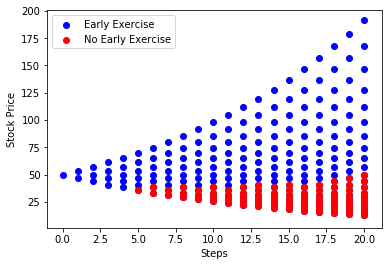

In [8]:
option = BinomialCRROption(S0=50, K=52, r=0.05, T=1, n=20, sigma=0.3, is_call=False, is_european=False)
print(option.price())
#print(option.option_price_tree())
option.exercise_frontier()

# Finite Differences

In [0]:
import numpy as np
import pylab
import matplotlib.pyplot as plt
import time

K = 100
Smax = 200
T = 1.0
sigma = 0.2
r = 0.1
M = 35
N = 20
h = Smax/(M+1.0)

#xj matrix
xj = np.zeros(M+2)
for j in range(0, M+2):
    xj[j] = j*h

delta_t = T/float(N)
t = np.zeros(N+1)
for j in range(0,N+1):
    t[j] = j*delta_t

In [0]:
#A matrix - we get a tridiagonal matrix
A = np.zeros((M+2,M+2))
for i in range(M+2):
    if i>0:
        A[i][i-1] = - (sigma*sigma)*(xj[i]*xj[i])/float(2*(h*h))
    A[i][i] = (sigma*sigma)*(xj[i]*xj[i])/float(h*h)+ r* xj[i]/h +r
    if i<M+1:
        A[i][i+1]=-(sigma*sigma)*(xj[i]*xj[i])/float(2*(h*h)) - r* xj[i]/h

In [0]:
#payoff matrix
g = np.zeros(M+2)
for i in range(0, M+2):
    g[i] = max(K-xj[i],0)

In [0]:
#calculating P matrix
P = np.zeros((M+2,N+1))
for i in range(0, M+2):
    P[i][0] = g[i]
for i in range(0, N):
    temp = np.zeros(M+2)
    temp1 = np.zeros(M+2)
    
    temp = P[:,i]-delta_t*np.matmul(A,P[:,i])
    for j in range(0, M+2):
        temp1[j] = max(temp[j], g[j])
    P[:,i+1] = temp1
    P[M+1,i+1] = 0

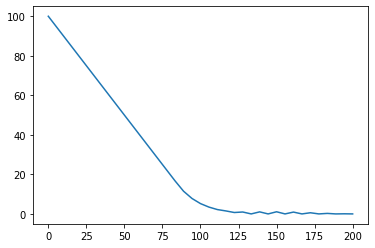

In [13]:
# M = 35
pylab.plot(xj, P[:,N])
plt.show()

In [0]:
B  = np.eye(M+2) + delta_t * A


In [0]:
def func(x,B,b,g):
    temp = np.zeros(len(x))
    y = np.matmul(B,x)
    for i in range(0,len(x)):
        temp[i] = min(x[i]-g[i], y[i]-b[i])
    return temp

In [0]:
def derivative(x,B,b,g):
    der = np.zeros((M+2,M+2))
    y = np.matmul(B,x)
    for j in range(M+2):
        for i in range(M+2):
            if y[i]-b[i]<=x[i]-g[i]:
                der[j][i] = B[j][i]
            elif i == j:
                der[j][i] = 1
            else:
                der[j][i] = 0
    return der

In [0]:
Price = np.zeros((M+2,N+1))
for i in range(0, M+2):
    Price[i][0] = g[i]

In [0]:
K1 = 1000
eps = 0.0000001
for i in range(0, N):
    b = Price[:,i]
    xx = np.zeros(M+2)
    for k in range(0,K1): 
        fx = func(xx,B,b,g)
        fxder = derivative(xx,B,b,g)
        xx = xx - np.dot(np.linalg.inv(fxder), fx)
        if max(np.abs(np.dot(np.linalg.inv(fxder), fx)))< eps: 
            break
    Price[:,i+1] = xx

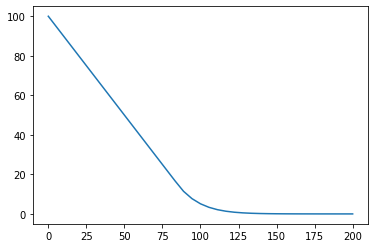

In [19]:
pylab.plot(xj, Price[:,N])
plt.show()

In [20]:
#Secant Method
xj = np.zeros(M+2)
for j in range(0, M+2):
    xj[j] = j*h

tolerance = 0.0001
Iterations = 100
N = 20
for i in range(0, N):
    b = Price[:,i]
    xx1 = np.ones(M+2)
    xx0 = np.zeros(M+2)
    xx2 = xx1
    for k in range(0,Iterations): 
        if abs((xx1-xx0)).any() <= tolerance or k >= Iterations:
            break
        else:
            xx2 = xx1 - func(xx1,B,b,g)*(xx1-xx0)/(func(xx1,B,b,g)-func(xx0,B,b,g))     
            np.nan_to_num(xx2)
            #print(xx2)
            #break
            xx1, xx0 = xx2, xx1
            np.nan_to_num(xx1)
    Price[:,i+1] = xx2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


[100.          94.44444444  88.88888889  83.33333333  77.77777778
  72.22222222  66.66666667  61.11111111  55.55555556  50.
  44.44444444  38.88888889  33.33333333  27.77777778  22.22222222
  16.66666667  11.11111111   5.55555556   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.        ]


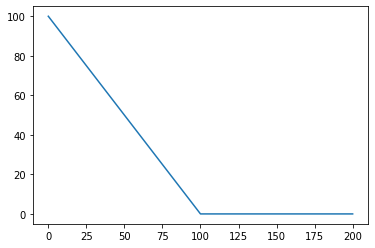

In [21]:
print(xx2) 
#print(steps)
pylab.plot(xj, Price[:,N])
plt.show()

# Provided by https://github.com/pranavsawant23